<a href="https://colab.research.google.com/github/danielecordano/NLP/blob/master/NLP_amazon_reviews_sentiment_GLOVE_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

!wget --no-check-certificate \
    https://raw.githubusercontent.com/KeithGalli/sklearn/master/data/sentiment/Books_small_10000.json \
    -O /tmp/reviews.json

embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .9


with open("/tmp/reviews.json", 'r') as f:
  sentences = []
  labels = []
  for line in f:
    item = json.loads(line)
    sentences.append(item['reviewText'])
    labels.append(int(item['overall'] >= 2.5))

print(len(sentences))
training_size = int(training_portion * len(sentences))
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;



--2020-04-03 11:24:35--  https://raw.githubusercontent.com/KeithGalli/sklearn/master/data/sentiment/Books_small_10000.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8063542 (7.7M) [text/plain]
Saving to: ‘/tmp/reviews.json’

/tmp/reviews.json   100%[===================>]   7.69M  27.8MB/s    in 0.3s    

2020-04-03 11:24:38 (27.8 MB/s) - ‘/tmp/reviews.json’ saved [8063542/8063542]

10000
32581
--2020-04-03 11:24:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (3

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 100)          3258200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [23]:
num_epochs = 25
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)


Epoch 1/25
282/282 [==============================] - 4s 13ms/step - loss: 0.2457 - accuracy: 0.9321 - val_loss: 0.2270 - val_accuracy: 0.9420
Epoch 2/25
282/282 [==============================] - 3s 10ms/step - loss: 0.2289 - accuracy: 0.9349 - val_loss: 0.2249 - val_accuracy: 0.9420
Epoch 3/25
282/282 [==============================] - 3s 10ms/step - loss: 0.2161 - accuracy: 0.9349 - val_loss: 0.2194 - val_accuracy: 0.9420
Epoch 4/25
282/282 [==============================] - 3s 10ms/step - loss: 0.2016 - accuracy: 0.9348 - val_loss: 0.2045 - val_accuracy: 0.9420
Epoch 5/25
282/282 [==============================] - 3s 10ms/step - loss: 0.1851 - accuracy: 0.9351 - val_loss: 0.2096 - val_accuracy: 0.9420
Epoch 6/25
282/282 [==============================] - 3s 10ms/step - loss: 0.1727 - accuracy: 0.9374 - val_loss: 0.2006 - val_accuracy: 0.9410
Epoch 7/25
282/282 [==============================] - 3s 10ms/step - loss: 0.1609 - accuracy: 0.9404 - val_loss: 0.2042 - val_accuracy: 0.9410

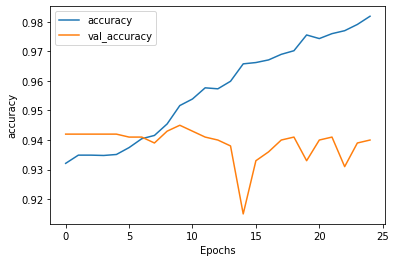

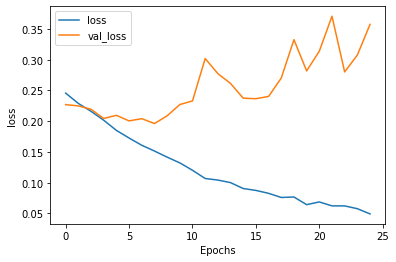

In [24]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [0]:
model.save("amazon_reviews_sentiment.h5")

In [27]:
new_reviews = ["This book was very easy to read. I really enjoyed it.", "This book is too trivial and boring","I am sure this book is chalk full of good info! However it is certainly not a beginners book to investing. If you're like me and have no idea what the definition of terms like 'net tangible assets', and 'sub working capital' are it may be best to find a true beginners book as a prequel to this one. Lots of good info I cant yet understand."]
new_reviews_numeric = tokenizer.texts_to_sequences(new_reviews)
new_reviews_padded = pad_sequences(new_reviews_numeric, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(new_reviews_padded);
print(predictions)

[[0.9975526 ]
 [0.00436827]
 [0.99175984]]
